# Deep Q-learning for trading

## Imports, Settings & Helpers

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from pathlib import Path
from time import time
from collections import deque
from random import sample, choice
import string

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import gym
from gym.envs.registration import register

### Settings

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
sns.set_style('whitegrid')

In [5]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [6]:
results_path = Path('results', 'trading_bot')
if not results_path.exists():
    results_path.mkdir(parents=True)

### Helper functions

In [7]:
def format_time(t):
    m_, s = divmod(t, 60)
    h, m = divmod(m_, 60)
    return '{:02.0f}:{:02.0f}:{:02.0f}'.format(h, m, s)

## Set up Gym Environment

### Register Trading Environment

In [8]:
trading_days = 252

In [9]:
register(
    id='trading-v0',
    entry_point='trading_env:TradingEnvironment',
    max_episode_steps=trading_days
)

### Initialize Trading Environment

In [10]:
trading_cost_bps = 1e-3
time_cost_bps = 1e-4

In [11]:
start_date = '2000-01-01'
end_date = '2018-03-20'

In [12]:
tickers = ['AAPL', 'KO']

In [13]:
trading_environment = gym.make('trading-v0', 
                               tickers=tickers,
                               trading_days=trading_days,
                               trading_cost_bps=trading_cost_bps,
                               time_cost_bps=time_cost_bps,
                               start_date=start_date,
                               end_date=end_date)
trading_environment.seed(42)

INFO:trading_env:trading_env logger started.
INFO:trading_env:loading data for AAPL...
INFO:trading_env:got data for AAPL...
INFO:trading_env:preprocessing data for AAPL...
INFO:trading_env:finished preprocessing for AAPL...
INFO:trading_env:loading data for KO...
INFO:trading_env:got data for KO...
INFO:trading_env:preprocessing data for KO...
INFO:trading_env:finished preprocessing for KO...


[42]

### Get Environment Params

In [14]:
state_dim = trading_environment.observation_space.shape[0]
num_actions = trading_environment.action_space.n
max_episode_steps = trading_environment.spec.max_episode_steps

## Data understanding

In [15]:
df = trading_environment.data_source.data

### Full data set

In [16]:
df

,,returns,ret_2,ret_5,ret_10,ret_21,rsi,macd,atr,stoch,ultosc
date,ticker,,,,,,,,,,
2000-02-18,AAPL,-0.031514,-0.763186,0.304509,0.224522,-0.389616,-0.601350,-0.148707,-0.815670,1.654582,0.158853
2000-02-22,AAPL,0.023011,-0.321852,-0.414578,-0.178152,-0.029840,-0.731141,-0.149169,-0.805305,0.613936,0.347936
2000-02-23,AAPL,0.021439,1.179787,-0.518884,-0.000972,0.579869,-0.240849,-0.149107,-0.801661,-0.455568,0.893520
2000-02-24,AAPL,-0.009032,0.272498,0.062931,0.134922,0.002670,0.513122,-0.149496,-0.799952,-1.112707,0.313370
2000-02-25,AAPL,-0.041927,-1.468153,-0.805843,-0.494775,-0.207043,0.201195,-0.152831,-0.799668,0.029140,-0.428566
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-14,KO,-0.017725,-0.963818,-0.084838,0.282724,-0.190142,-0.067891,-1.772687,1.907278,2.209773,-0.004946
2018-03-15,KO,-0.002513,-1.149147,-0.695987,0.078103,-0.336864,-0.782081,-1.672206,1.797199,2.091253,-0.431538
2018-03-16,KO,-0.004809,-0.436475,-1.166088,-0.237829,-0.390953,-1.535603,-1.615803,1.750439,1.902853,-1.013160


--- Shape ---
Number of records: 9095
Number of attributes: 10

--- Types ---
returns    float64
ret_2      float64
ret_5      float64
ret_10     float64
ret_21     float64
rsi        float64
macd       float64
atr        float64
stoch      float64
ultosc     float64
dtype: object

--- Statistical measures for each attribute ---
           returns         ret_2         ret_5        ret_10        ret_21  \
count  9095.000000  9.095000e+03  9.095000e+03  9.095000e+03  9.095000e+03   
mean      0.000747  6.933553e-18  2.207018e-17  2.070300e-17 -1.015619e-17   
std       0.020423  1.000055e+00  1.000055e+00  1.000055e+00  1.000055e+00   
min      -0.518692 -1.522140e+01 -1.060288e+01 -7.981114e+00 -6.089871e+00   
25%      -0.007302 -4.691591e-01 -5.082822e-01 -5.158551e-01 -5.187310e-01   
50%       0.000456 -5.172618e-03  1.965607e-02  3.155445e-02  1.758471e-02   
75%       0.008736  4.819944e-01  5.162416e-01  5.560226e-01  5.967227e-01   
max       0.139050  8.193063e+00  6.088193e+0

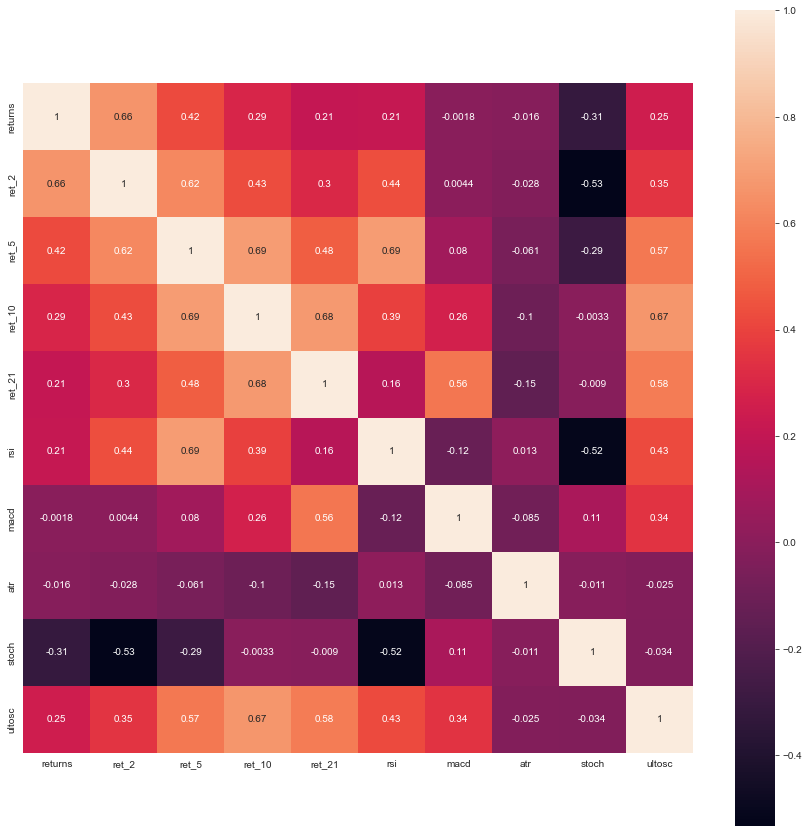

In [17]:
print("--- Shape ---")
print("Number of records:", df.shape[0])
print("Number of attributes:", df.shape[1])
print()
print("--- Types ---")
print(df.dtypes)
print()
print("--- Statistical measures for each attribute ---")
print(df.describe())
print()
print("--- Correlation ---")
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)
plt.show()

### Per ticker data sets

AAPL
                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
2000-02-18 AAPL   -0.031514 -0.763186  0.304509  0.224522 -0.389616 -0.601350   
2000-02-22 AAPL    0.023011 -0.321852 -0.414578 -0.178152 -0.029840 -0.731141   
2000-02-23 AAPL    0.021439  1.179787 -0.518884 -0.000972  0.579869 -0.240849   
2000-02-24 AAPL   -0.009032  0.272498  0.062931  0.134922  0.002670  0.513122   
2000-02-25 AAPL   -0.041927 -1.468153 -0.805843 -0.494775 -0.207043  0.201195   
...                     ...       ...       ...       ...       ...       ...   
2018-03-14 AAPL   -0.008501 -0.566396  0.241882 -0.128407  0.601629  0.035484   
2018-03-15 AAPL    0.001177 -0.269370  0.066513  0.109331  0.519951 -0.925457   
2018-03-16 AAPL   -0.003526 -0.131302 -0.300627 -0.022697  0.320474 -1.513717   
2018-03-19 AAPL   -0.015279 -0.585855 -0.737153 -0.258034 -0.107324 -1.513717   
2018-03-20 AAPL   -0.00

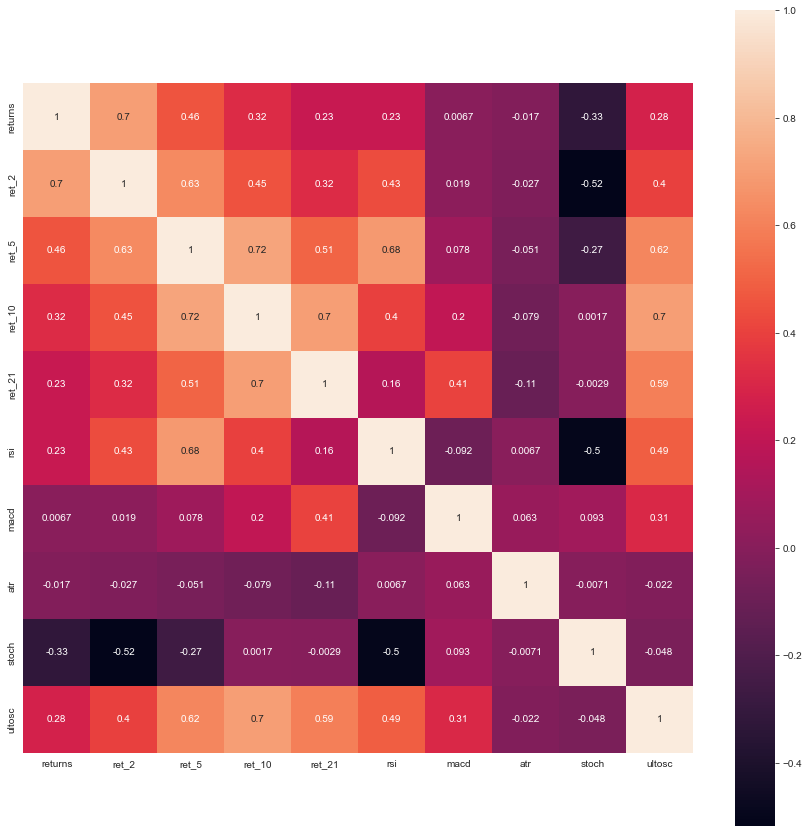

KO
                    returns     ret_2     ret_5    ret_10    ret_21       rsi  \
date       ticker                                                               
2000-02-18 KO     -0.017779 -2.283624 -2.815304 -2.458148 -4.441812 -1.535603   
2000-02-22 KO      0.007201 -0.624335 -1.666639 -2.557613 -4.562577 -1.396695   
2000-02-23 KO     -0.009662 -0.172114 -2.980374 -2.934164 -4.244436 -1.341711   
2000-02-24 KO     -0.028098 -2.105833 -2.623563 -3.547575 -4.911385 -1.341711   
2000-02-25 KO     -0.022485 -2.795251 -2.593727 -3.960022 -4.595131 -1.480619   
...                     ...       ...       ...       ...       ...       ...   
2018-03-14 KO     -0.017725 -0.963818 -0.084838  0.282724 -0.190142 -0.067891   
2018-03-15 KO     -0.002513 -1.149147 -0.695987  0.078103 -0.336864 -0.782081   
2018-03-16 KO     -0.004809 -0.436475 -1.166088 -0.237829 -0.390953 -1.535603   
2018-03-19 KO     -0.004602 -0.551494 -1.099095 -0.469335 -0.773829 -1.535603   
2018-03-20 KO     -0.0023

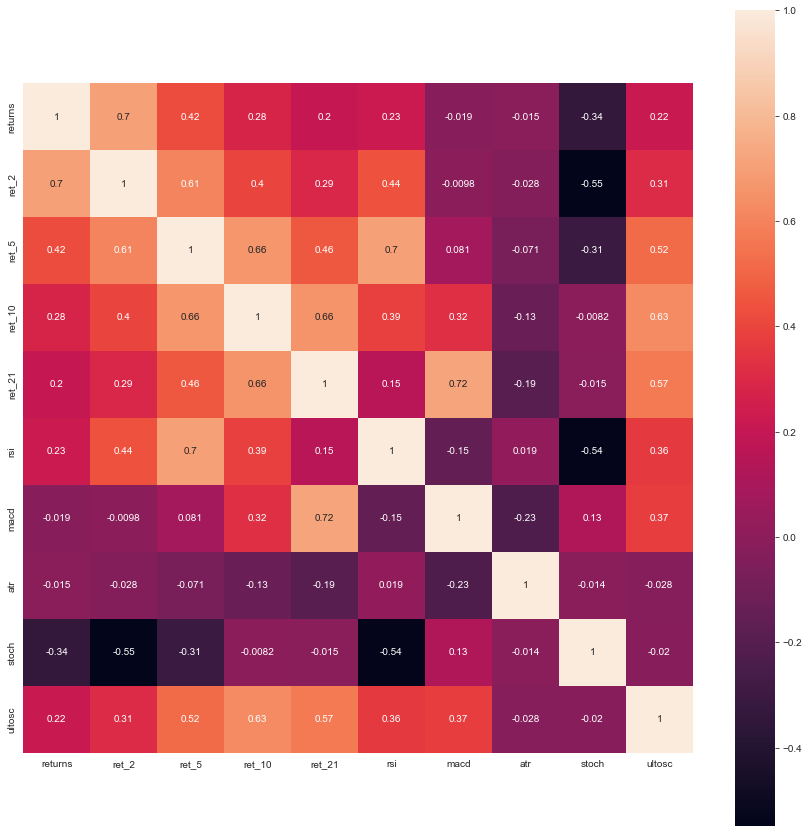

In [18]:
for ticker in tickers:
    print(ticker)
    df_ticker = df.loc[(slice(None), ticker), :]
    print(df_ticker)
    print("--- Shape ---")
    print("Number of records:", df_ticker.shape[0])
    print("Number of attributes:", df_ticker.shape[1])
    print()
    print("--- Types ---")
    print(df_ticker.dtypes)
    print()
    print("--- Statistical measures for each attribute ---")
    print(df_ticker.describe())
    print()
    print("--- Correlation ---")
    plt.figure(figsize=(15, 15))
    sns.heatmap(df_ticker.corr(), square=True, annot=True)
    plt.show()

## Define Trading Agent

In [19]:
class DDQNAgent:
    def __init__(self, state_dim,
                 num_actions,
                 learning_rate,
                 gamma,
                 epsilon_start,
                 epsilon_end,
                 epsilon_decay_steps,
                 epsilon_exponential_decay,
                 replay_capacity,
                 architecture,
                 l2_reg,
                 tau,
                 batch_size,
                 train,
                 ticker):

        self.state_dim = state_dim
        self.num_actions = num_actions
        self.experience = deque([], maxlen=replay_capacity)
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.architecture = architecture
        self.l2_reg = l2_reg
        self.ticker = ticker

        self.online_network = self.build_model()
        self.target_network = self.build_model(trainable=False)
        self.update_target()

        if(not train):
            self.epsilon = 0.0
        else:
            self.epsilon = epsilon_start
        self.epsilon_decay_steps = epsilon_decay_steps
        self.epsilon_decay = (epsilon_start - epsilon_end) / epsilon_decay_steps
        self.epsilon_exponential_decay = epsilon_exponential_decay
        self.epsilon_history = []

        self.total_steps = self.train_steps = 0
        self.episodes = self.episode_length = self.train_episodes = 0
        self.steps_per_episode = []
        self.episode_reward = 0
        self.rewards_history = []

        self.batch_size = batch_size
        self.tau = tau
        self.losses = []
        self.idx = tf.range(batch_size)
        self.train = train

    def build_model(self, trainable=True):
        layers = []
        n = len(self.architecture)
        for i, units in enumerate(self.architecture, 1):
            layers.append(Dense(units=units,
                                input_dim=self.state_dim if i == 1 else None,
                                activation='relu',
                                kernel_regularizer=l2(self.l2_reg),
                                name=f'Dense_{i}',
                                trainable=trainable))
        layers.append(Dropout(.1))
        layers.append(Dense(units=self.num_actions,
                            trainable=trainable,
                            name='Output'))
        model = Sequential(layers)
        model.compile(loss='mean_squared_error',
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target(self):
        self.target_network.set_weights(self.online_network.get_weights())

    def load_model_weights(self, model_weights_filepath):
        self.online_network.load_weights(model_weights_filepath)
        print('Model weights loaded from: ' + model_weights_filepath)
    
    def save_model_weights(self, num_episodes, folder_id):
        model_weights_filepath = 'weights/{0}_episodes/{1}/model_{2}.h5'.format(num_episodes, folder_id, self.ticker)
        if(not Path(model_weights_filepath).exists()):
            Path(model_weights_filepath).mkdir(parents=True)
        self.online_network.save_weights(model_weights_filepath)
        print('Model weights saved at: ' + model_weights_filepath)

    def epsilon_greedy_policy(self, state):
        self.total_steps += 1
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.num_actions)
        q = self.online_network.predict(state, verbose=0)
        return np.argmax(q, axis=1).squeeze()

    def memorize_transition(self, s, a, r, s_prime, not_done):
        if not_done:
            self.episode_reward += r
            self.episode_length += 1
        else:
            if self.train:
                if self.episodes < self.epsilon_decay_steps:
                    self.epsilon -= self.epsilon_decay
                else:
                    self.epsilon *= self.epsilon_exponential_decay

            self.episodes += 1
            self.rewards_history.append(self.episode_reward)
            self.steps_per_episode.append(self.episode_length)
            self.episode_reward, self.episode_length = 0, 0

        self.experience.append((s, a, r, s_prime, not_done))

    def experience_replay(self):
        if self.batch_size > len(self.experience):
            return
        minibatch = map(np.array, zip(*sample(self.experience, self.batch_size)))
        states, actions, rewards, next_states, not_done = minibatch

        next_q_values = self.online_network.predict_on_batch(next_states)
        best_actions = tf.argmax(next_q_values, axis=1)

        next_q_values_target = self.target_network.predict_on_batch(next_states)
        target_q_values = tf.gather_nd(next_q_values_target,
                                       tf.stack((self.idx, tf.cast(best_actions, tf.int32)), axis=1))

        targets = rewards + not_done * self.gamma * target_q_values

        q_values = self.online_network.predict_on_batch(states)
        q_values[(self.idx, actions)] = targets

        loss = self.online_network.train_on_batch(x=states, y=q_values)
        self.losses.append(loss)

        if self.total_steps % self.tau == 0:
            self.update_target()

## Define hyperparameters

In [20]:
gamma = .99,  # discount factor
tau = 100  # target network update frequency

### NN Architecture

In [21]:
architecture = (256, 256)  # units per layer
learning_rate = 0.0001  # learning rate
l2_reg = 1e-6  # L2 regularization

### Experience Replay

In [22]:
replay_capacity = int(1e6)
batch_size = 4096

### $\epsilon$-greedy Policy

In [23]:
epsilon_start = 1.0
epsilon_end = .01
epsilon_decay_steps = 250
epsilon_exponential_decay = .99

### Trainable

In [24]:
train = True

## Create DDQN Agent

In [25]:
tf.keras.backend.clear_session()

In [26]:
ddqn = {ticker: DDQNAgent(state_dim=state_dim,
                 num_actions=num_actions,
                 learning_rate=learning_rate,
                 gamma=gamma,
                 epsilon_start=epsilon_start,
                 epsilon_end=epsilon_end,
                 epsilon_decay_steps=epsilon_decay_steps,
                 epsilon_exponential_decay=epsilon_exponential_decay,
                 replay_capacity=replay_capacity,
                 architecture=architecture,
                 l2_reg=l2_reg,
                 tau=tau,
                 batch_size=batch_size,
                 train=train,
                 ticker=ticker) for ticker in tickers}

## Run Experiment

### Set parameters

In [27]:
total_steps = 0
max_episodes = 50

### Initialize variables

These variables will keep track of the agent results at the end of every episode

In [28]:
episode_time = []
navs = {ticker: [] for ticker in tickers}
market_navs = {ticker: [] for ticker in tickers}
diffs = {ticker: [] for ticker in tickers}
episode_eps = {ticker: [] for ticker in tickers}

### Load model weights

In [29]:
folder_id = 'fsdsgs'
model_weights_filepaths = {ticker: 'weights/100_episodes/{0}/model_{1}.h5'.format(folder_id, ticker) for ticker in tickers}
if(not train):
    for ticker in tickers:
        ddqn[ticker].load_model_weights(model_weights_filepaths[ticker])

### Visualization

In [30]:
def track_results(episode, nav_ma_100, nav_ma_10,
                  market_nav_100, market_nav_10,
                  win_ratio, total, epsilon, ticker):
    time_ma = np.mean([episode_time[-100:]])
    T = np.sum(episode_time)
    
    template = '{:>4d} | {} | Agent: {:>6.1%} ({:>6.1%}) | '
    template += 'Market: {:>6.1%} ({:>6.1%}) | '
    template += 'Wins: {:>5.1%} | eps: {:>6.3f} | {}'
    print(template.format(episode, format_time(total), 
                          nav_ma_100-1, nav_ma_10-1, 
                          market_nav_100-1, market_nav_10-1, 
                          win_ratio, epsilon, ticker))

## Train Agent

In [31]:
start = time()
results = []
for episode in range(1, max_episodes + 1):
    current_states = trading_environment.reset()
    for episode_step in range(max_episode_steps):
        actions = {}
        for ticker in tickers:
            action = ddqn[ticker].epsilon_greedy_policy(current_states[ticker].reshape(-1, state_dim))
            actions[ticker] = action
        
        next_states, rewards, done, _ = trading_environment.step(actions)

        for ticker in tickers:
            ddqn[ticker].memorize_transition(current_states[ticker], 
                                    actions[ticker], 
                                    rewards[ticker], 
                                    next_states[ticker], 
                                    0.0 if done else 1.0)
            if ddqn[ticker].train:
                ddqn[ticker].experience_replay()
        if done:
            break
        current_states = next_states.copy()

    # get DataFrame with seqence of actions, returns and nav values
    result = trading_environment.env.simulator.result()
    
    for ticker in tickers:
        # get results of last step
        final = pd.DataFrame({c: [result[c][ticker][-1]] for c in result.columns}).iloc[0]

        # apply return (net of cost) of last action to last starting nav 
        nav = final.nav * (1 + final.strategy_return)
        navs[ticker].append(nav)

        # market nav 
        market_nav = final.market_nav
        market_navs[ticker].append(market_nav)

        # track difference between agent an market NAV results
        diff = nav - market_nav
        diffs[ticker].append(diff)
    
        if episode % 10 == 0:
            track_results(episode, 
                        # show mov. average results for 100 (10) periods
                        np.mean(navs[ticker][-100:]), 
                        np.mean(navs[ticker][-10:]), 
                        np.mean(market_navs[ticker][-100:]), 
                        np.mean(market_navs[ticker][-10:]), 
                        # share of agent wins, defined as higher ending nav
                        np.sum([s > 0 for s in diffs[ticker][-100:]])/min(len(diffs[ticker]), 100), 
                        time() - start, ddqn[ticker].epsilon, ticker)
        if len(diffs[ticker]) > 25 and all([r > 0 for r in diffs[ticker][-25:]]):
            print(result.tail())
            break
    if episode % 10 == 0:
        print("---------------------------------------------------------------------------------------------------------")

trading_environment.close()

  10 | 00:00:12 | Agent: -32.1% (-32.1%) | Market:  36.4% ( 36.4%) | Wins: 10.0% | eps:  0.960 | AAPL
  10 | 00:00:12 | Agent: -23.9% (-23.9%) | Market:   2.9% (  2.9%) | Wins: 10.0% | eps:  0.960 | KO
---------------------------------------------------------------------------------------------------------


  20 | 00:02:44 | Agent: -31.1% (-30.0%) | Market:  29.8% ( 23.3%) | Wins:  5.0% | eps:  0.921 | AAPL
  20 | 00:02:44 | Agent: -24.1% (-24.4%) | Market:   3.4% (  3.8%) | Wins:  5.0% | eps:  0.921 | KO
---------------------------------------------------------------------------------------------------------
  30 | 00:09:13 | Agent: -31.5% (-32.3%) | Market:  29.8% ( 29.8%) | Wins:  3.3% | eps:  0.881 | AAPL
  30 | 00:09:13 | Agent: -23.7% (-23.0%) | Market:   3.7% (  4.5%) | Wins:  3.3% | eps:  0.881 | KO
---------------------------------------------------------------------------------------------------------
  40 | 00:15:56 | Agent: -29.2% (-22.6%) | Market:  48.6% (105.0%) | Wins:  5.0% | eps:  0.842 | AAPL
  40 | 00:15:56 | Agent: -22.3% (-18.1%) | Market:   3.5% (  2.7%) | Wins:  7.5% | eps:  0.842 | KO
---------------------------------------------------------------------------------------------------------
  50 | 00:22:53 | Agent: -27.6% (-20.9%) | Market:  43.1% ( 20.8%) | Wins:  

### Save trained model

In [38]:
if(train):
    folder_id = ''.join(choice(string.digits + string.ascii_lowercase) for i in range(10))
    for ticker in tickers:
        ddqn[ticker].save_model_weights(max_episodes, folder_id)

False


## Results

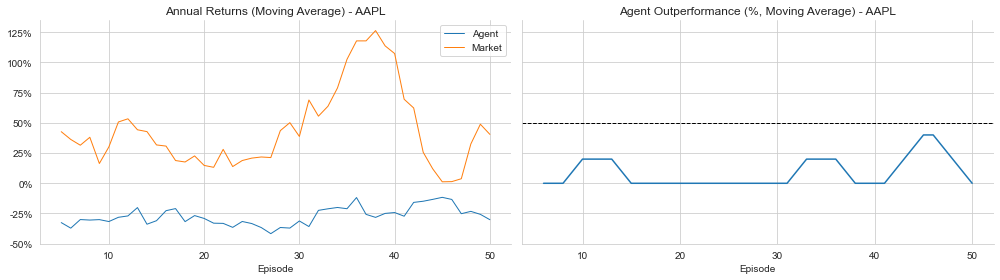

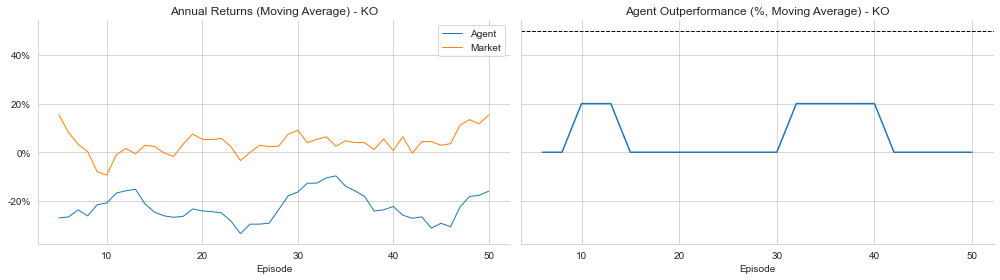

In [35]:
for ticker in tickers:
    results = pd.DataFrame({'Episode': list(range(1, episode+1)),
                            'Agent': navs[ticker],
                            'Market': market_navs[ticker],
                            'Difference': diffs[ticker]}).set_index('Episode')

    results['Strategy Wins (%)'] = (results.Difference > 0).rolling(int(max_episodes*0.10)).sum()

    results.to_csv(results_path / 'results_{0}.csv'.format(ticker), index=False)
    
    # Evaluate results
    fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

    df1 = (results[['Agent', 'Market']]
        .sub(1)
        .rolling(int(max_episodes*0.10))
        .mean())
    df1.plot(ax=axes[0],
            title='Annual Returns (Moving Average) - {0}'.format(ticker),
            lw=1)

    df2 = results['Strategy Wins (%)'].div(int(max_episodes*0.10)).rolling(int(max_episodes*0.05)).mean()
    df2.plot(ax=axes[1],
            title='Agent Outperformance (%, Moving Average) - {0}'.format(ticker))

    for ax in axes:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        ax.xaxis.set_major_formatter(
            FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))
    axes[1].axhline(.5, ls='--', c='k', lw=1)

    sns.despine()
    fig.tight_layout()
    fig.savefig(results_path / 'performance_{0}'.format(ticker), dpi=300)